### import packages

In [1]:
import datascience as ds
from datascience import *
import numpy as np
from graphviz import Source
import pandas as pd
import re
import string
from copy import copy
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBoostClassifier
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

import gensim
%matplotlib inline

### read the data

In [2]:
tagged = pd.read_csv('cleaned_tagged.csv', sep=',')
Relevant = np.array([0]*tagged.size)
Relevant[tagged[tagged.sentiment!=-1].index.tolist()] = 1
tagged['Relevant'] = pd.Series(Relevant, name='Relevant')
tagged = tagged.drop(tagged.columns[0], axis=1).reset_index(drop=True)
tagged.to_csv('relevant_binary_tagged.csv')

In [3]:
df = ds.Table.read_table('relevant_binary_tagged.csv', sep=',')
df

Unnamed: 0,user_id,user_name,tweet_time,location,text,sentiment,Relevant
0,802657195661742080,Christine Warren,Wed Sep 12 01:38:14 +0000 2018,Fremont CA,2 american lives were just lost in tennessee potus pleas ...,0,1
1,1039245812230893570,Trumpservative,Wed Sep 12 01:38:16 +0000 2018,Tulsa OK,realfarmacist realdonaldtrump tuckercarlson our great le ...,1,1
2,282084840,Darrel Sheldon #MAGAVETERAN,Wed Sep 12 01:38:18 +0000 2018,None,rightgottweets rev out the trumptrain for bluemilwaukee ...,0,1
3,62315639,Queer Liberal Voting Snowflake,Wed Sep 12 01:38:18 +0000 2018,Big Sandy Texas,tennessee is suffering after shooting takes 2 lives potu ...,0,1
4,823307049266245633,don jones #veteran (K),Wed Sep 12 01:38:19 +0000 2018,United States,sassytjoy bcmsolt fightinirish109 dybarb wolfiev3 kevinh ...,-1,0
5,340428574,DelcoGal,Wed Sep 12 01:38:21 +0000 2018,Pennsylvania,loudobbs redwaverising sidneypowell1 this years midterm ...,1,1
6,1603928228,Julz,Wed Sep 12 01:38:22 +0000 2018,MIAATLPGH,2 lives were just lost in tennessee potus its time to do ...,0,1
7,1865678516,Barbara Kuczinski,Wed Sep 12 01:38:22 +0000 2018,None,mollympengra realjameswoods obama mollympengra oh hon cn ...,1,1
8,59288409,Josh Steed PhD,Wed Sep 12 01:38:25 +0000 2018,Arkansas,jillibean557 msm is repulsive they do nothing but lie an ...,0,1
9,325172419,Mrs. Linz,Wed Sep 12 01:38:25 +0000 2018,BC Canada,jc61384960 loricoutler amymek muslims coming illegally a ...,2,1


### data preprocessing

In [4]:
relevant_tweet = df.where('Relevant', are.equal_to(1))
irrelevant_tweet = df.where('Relevant', are.equal_to(0))

In [5]:
relevant_tweet_cnt = relevant_tweet.num_rows
irrelevant_tweet_cnt = irrelevant_tweet.num_rows

In [6]:
relevant_tweet_cnt, irrelevant_tweet_cnt

(1133, 163)

In [7]:
relevant_training_size = round(relevant_tweet_cnt*0.8*0.6)
irrelevant_training_size = round(irrelevant_tweet_cnt*0.8)

In [8]:
relevant_training_size, irrelevant_training_size

(544, 130)

In [9]:
relevant_train_idx = list(range(relevant_training_size))
irrelevant_train_idx = list(range(irrelevant_training_size))
relevant_test_idx = list(range(relevant_tweet_cnt))[int(relevant_training_size*1.95):]
irrelevant_test_idx = list(range(irrelevant_tweet_cnt))[irrelevant_training_size:]


relevant_training_text = list(relevant_tweet.take(relevant_train_idx)['text'])
irrelevant_training_text = list(irrelevant_tweet.take(irrelevant_train_idx)['text'])
relevant_training_relevant = list(relevant_tweet.take(relevant_train_idx)['Relevant'])
irrelevant_training_relevant = list(irrelevant_tweet.take(irrelevant_train_idx)['Relevant'])

relevant_testing_text = list(relevant_tweet.take(relevant_test_idx)['text'])
irrelevant_testing_text = list(irrelevant_tweet.take(irrelevant_test_idx)['text'])
relevant_testing_relevant = list(relevant_tweet.take(relevant_test_idx)['Relevant'])
irrelevant_testing_relevant = list(irrelevant_tweet.take(irrelevant_test_idx)['Relevant'])

X_train = relevant_training_text + irrelevant_training_text
y_train = relevant_training_relevant + irrelevant_training_relevant
X_test = relevant_testing_text + irrelevant_testing_text
y_test = relevant_testing_relevant + irrelevant_testing_relevant


In [10]:
X_train[:10], X_train[-10:], y_train[:10], y_train[-10:]

(['2 american lives were just lost in tennessee potus please end the suffering backfiretrump',
  'realfarmacist realdonaldtrump tuckercarlson our great leader president donald j trump can hold his breath for',
  'rightgottweets rev out the trumptrain for bluemilwaukee libsrnutz mobofa josueda54362271 tanyakv boshellsandi',
  'tennessee is suffering after shooting takes 2 lives potus stop the bloodshed backfiretrump',
  'loudobbs redwaverising sidneypowell1 this years midterm is the most important in the history of our country we dont just need',
  '2 lives were just lost in tennessee potus its time to do something backfiretrump',
  'mollympengra realjameswoods obama mollympengra oh hon cnn reports the truth as fast as they can dream it up potus maga',
  'jillibean557 msm is repulsive they do nothing but lie and undermine presidenttrump',
  'jc61384960 loricoutler amymek muslims coming illegally across the southern border maga kag buildthatwall votered buildthedamn',
  'sirstevotimothy 

In [11]:
len(X_train), len(X_test)

(674, 106)

In [12]:
X_test[:10], X_test[-10:], y_test[:10], y_test[-10:]

(['whats more american than mcdonalds amp the potus makeamericagreatagain',
  'pahlbrighteyes it is an allout bid by donald trump to end the icc the worlds foremost criminal tribunal and with it the very co',
  'obama gave amnesty to millions amp changed regulations in favor of illegals for employment amp thats how social sec',
  'realdonaldtrump is not a legitimate potus he stole election2016 with the votes of russian hackers',
  'prosperous1776 17 years ago terrorists attacked our country we will never forget maga kag potus trump news votered nodaca w',
  'digiezone the little that bobwoodward shared tonight in his interview with msnbcs rachelmaddow about his book fear and the donald',
  'jtpower999 good word brother buildthatwall',
  'nedprice msnbc we support potus 10000000 we see through the bs fakenews cnn msnbc abc cbs velshiruhle nicolledwallace theview',
  'congress why is one of your members allowed to do this she is inciting hate toward our potus and his supporters',
  'pame

In [13]:
len(X_test), len(y_test)

(106, 106)

### Model (Bag of Words + DTree)

In [14]:
vect = CountVectorizer(
     analyzer="word", ngram_range=([1,2]), tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000)
# vect = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l1', encoding='latin-1', 
#                         ngram_range=(1,2), stop_words='english')
X_train_vect = vect.fit_transform(X_train).todense()
X_test_vect = vect.transform(X_test)
X_train_vect.shape, X_test_vect.shape

((674, 3000), (106, 3000))

In [15]:
clf = DecisionTreeClassifier(criterion = 'entropy',
                            random_state = 100,
                            max_depth = 35,
                            min_samples_leaf = 2)
clf = RandomForestClassifier(random_state=100,
                             n_estimators=60, 
                             criterion='entropy', 
                             n_jobs=4)
# clf = XGBoostClassifier(max_depth=5, n_estimators=5)
clf = LogisticRegression()
clf.fit(X_train_vect, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
# dot_data = tree.export_graphviz(clf, out_file=None, feature_names=vect.get_feature_names())
# graph = Source(dot_data)
# graph.render('RelevantClassifier')
# graph

In [17]:
y_pred = clf.predict(X_test_vect)
np.mean([cross_val_score(clf, X_train_vect, y_train, cv=8)])

0.8383228291316527

In [18]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 2, 31],
       [ 2, 71]])

In [1010]:
def plot_cm(cm, title='Confusion matrix', cmap=plt.cm.Blues, classes=['Relevant', 'Irrelevant']):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    target_names = classes
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

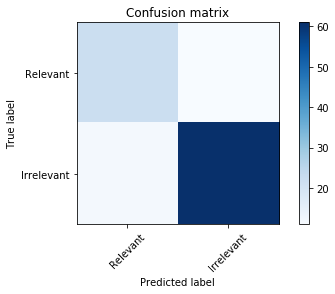

In [1011]:
plot_cm(metrics.confusion_matrix(y_test, y_pred))